In [97]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import os
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
# Vérification du répertoire courant
print("Dossier courant :", os.getcwd())
print("Fichiers visibles :", os.listdir())

Dossier courant : C:\Users\abotsi\Desktop\Projet_pro\MLOPS_project
Fichiers visibles : ['requirements.txt', 'text.csv', 'twitter_emotion_detection.ipynb']


In [55]:

# Positionnement dans le repertoire courant : 
os.chdir(r"C:\Users\abotsi\Desktop\Projet_pro\MLOPS_project")
print("Dossier courant :", os.getcwd())


Dossier courant : C:\Users\abotsi\Desktop\Projet_pro\MLOPS_project


### Data Ingestion

In [56]:
df = pd.read_csv('text.csv')

df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [57]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   Unnamed: 0  416809 non-null  int64
 1   text        416809 non-null  str  
 2   label       416809 non-null  int64
dtypes: int64(2), str(1)
memory usage: 9.5 MB


In [58]:
# delete tweet id
df.drop(columns=['Unnamed: 0'],inplace=True)
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [59]:
tri_map = {
    0: 0,
    1: 0,
    2: 1,
    3: 1,
    4: 2,
    5: 2
}

df["label"] = df["label"].map(tri_map)
final_df = df.copy()

In [60]:
final_df.sample(5)

,text,label
289029,i wanted to go to originally and whilst i feel...,0
212347,i feel myself getting annoyed more easily in t...,1
246447,i don t know if he s necessarily satirizing hi...,0
266746,i feel a little overwhelmed because there is n...,2
401356,i just hate the feeling of being ignored and s...,0


In [61]:
final_df.shape

(416809, 2)

In [62]:
final_df.head()

,text,label
0,i just feel really helpless and heavy hearted,2
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,2
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,2


### Data Preprocessing

In [63]:
# Téléchargements (à faire une fois)
nltk.download("wordnet")
nltk.download("stopwords")

_lemmatizer = WordNetLemmatizer()

# Stopwords: on garde les négations/contrastes
STOP_WORDS = set(stopwords.words("english")) - {"not", "but", "however", "no", "yet", "nor"}

URL_PATTERN = re.compile(r"https?://\S+|www\.\S+")

PUNCT_PATTERN = re.compile(r"[%s]" % re.escape(r"""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""))

def removing_urls(text: str) -> str:
    return URL_PATTERN.sub("", text)

def removing_punctuations(text: str) -> str:
    text = PUNCT_PATTERN.sub(" ", text)
    text = text.replace("؛", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lower_case(text: str) -> str:
    return text.lower()

def removing_numbers(text: str) -> str:
    return re.sub(r"\d+", "", text)

def remove_stop_words(text: str) -> str:
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOP_WORDS]
    return " ".join(tokens)

def lemmatization(text: str) -> str:
    tokens = text.split()
    tokens = [_lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

def remove_long_tokens(text, max_len=20):
    return " ".join([w for w in text.split() if len(w) <= max_len])

def normalized_sentence(sentence: str) -> str:
    # Gestion NaN / None
    if sentence is None or (isinstance(sentence, float) and np.isnan(sentence)):
        return ""

    sentence = str(sentence)

    sentence = removing_urls(sentence)
    sentence = removing_punctuations(sentence)
    sentence = lower_case(sentence)
    sentence = removing_numbers(sentence)
    sentence = remove_long_tokens(sentence)
    sentence = remove_stop_words(sentence)
    sentence = lemmatization(sentence)

    return sentence


def normalize_df(df, text_col="text", out_col="text_norm", min_words=3):
    df = df.copy()
    df[out_col] = df[text_col].apply(normalized_sentence)
    # retirer les phrases trop courtes
    df.loc[df[out_col].str.split().str.len() < min_words, out_col] = np.nan
    df = df.dropna(subset=[out_col])
    return df

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abotsi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abotsi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
#test
normalized_sentence("That's it? It's done already? This is one")

'done already one'

In [65]:
final_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   text    416809 non-null  str  
 1   label   416809 non-null  int64
dtypes: int64(1), str(1)
memory usage: 6.4 MB


In [66]:
## Mise en propre des données
final_df = normalize_df(final_df, text_col="text", out_col="text_norm", min_words=3)

final_df.info()

train_data, test_data = train_test_split(final_df, test_size=0.2, random_state=42)

<class 'pandas.DataFrame'>
Index: 409155 entries, 0 to 416808
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   text       409155 non-null  str  
 1   label      409155 non-null  int64
 2   text_norm  409155 non-null  str  
dtypes: int64(1), str(2)
memory usage: 12.5 MB


In [67]:
train_data.shape

(327324, 3)

In [68]:
test_data.shape

(81831, 3)

### feature engineering

In [69]:
# transforme la colonne pandas en array NumPy

X_train = train_data['text_norm'].values
y_train = train_data['label'].values

X_test = test_data['text_norm'].values
y_test = test_data['label'].values

In [71]:
train_data["text_norm"].head(10)


236399    prefer second version feel user friendly best ...
137887    since starting school till feeling kind useles...
334430                            im feeling tortured right
88475          even released weird feeling toward hated one
246147                                 said feel ugly today
383851    sometimes feel stressed running late day early...
11043     feel perverse first scent caught turned someth...
202833                feel weird going event though anymore
370978                   hate feeling way glad pass quickly
260931    dont usually wear sleeveless top dress feel in...
Name: text_norm, dtype: str

In [98]:
# Apply Bag of Words (CountVectorizer) : Création du Bag of Words

vectorizer_bow = CountVectorizer( min_df=5, # mot doit apparaître dans au moins 5 documents pour être gardé
                             max_df=0.9, # Un mot qui apparaît dans plus de 90 % des documents est supprimé
                             token_pattern = r"\b[a-z]{3,15}\b", # Un token valide doit respecter exactement ce pattern regex
                             ngram_range=(1, 2))

# Fit the vectorizer on the training data and transform it
X_train_bow = vectorizer_bow.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_bow = vectorizer_bow.transform(X_test)

# Apply TF-IDF (TfidfVectorizer) 

vectorizer_tfidf = TfidfVectorizer(
    min_df=5,                      # même seuil que BoW
    max_df=0.9,                    # même seuil que BoW
    token_pattern=r"\b[a-z]{3,15}\b",  # même règle lexicale
    ngram_range=(1, 2),            # unigram + bigram (valeur ajoutée)
    sublinear_tf=True,             # log(1 + tf) → plus robuste
    norm="l2"                      # normalisation standard
)

X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

In [100]:
# Visualiser quelques lignes seulement

n = 10  # nombre de lignes à visualiser

df_visu = pd.DataFrame(
    X_train_bow[:n].toarray(),
    columns=vectorizer_bow.get_feature_names_out()
)

df_visu["label"] = y_train[:n]
df_visu


,aaaaall,aaron,aback,abandon,abandoned,abandoning,abandonment,abba,abbey,abby,...,zone not,zoned,zoning,zoo,zoom,zoom class,zoom grey,zooming,zumba,zumba class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
n = 10  # nombre de lignes à visualiser

df_visu_tfidf = pd.DataFrame(
    X_train_tfidf[:n].toarray(),
    columns=vectorizer_tfidf.get_feature_names_out()
)

df_visu_tfidf["label"] = y_train[:n]

df_visu_tfidf


,aaaaall,aaron,aback,abandon,abandoned,abandoning,abandonment,abba,abbey,abby,...,zone not,zoned,zoning,zoo,zoom,zoom class,zoom grey,zooming,zumba,zumba class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Matplotlib is building the font cache; this may take a moment.


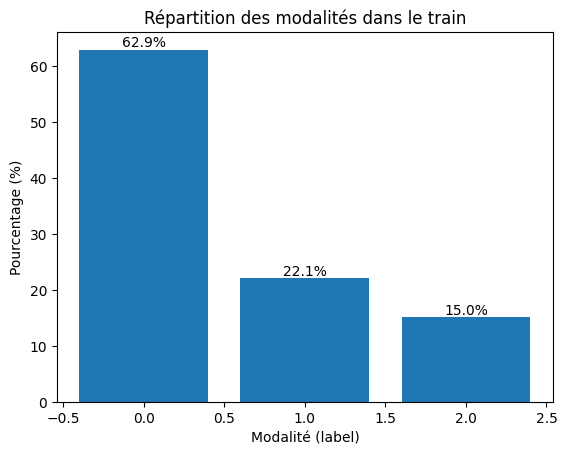

In [88]:
import numpy as np
import matplotlib.pyplot as plt
# Graphe des modalités en pourcentage (train)

# Comptage des classes
classes, counts = np.unique(y_train, return_counts=True)

# Conversion en pourcentage
percentages = counts / counts.sum() * 100

# Plot
plt.figure()
plt.bar(classes, percentages)
plt.xlabel("Modalité (label)")
plt.ylabel("Pourcentage (%)")
plt.title("Répartition des modalités dans le train")

# Afficher les valeurs sur les barres
for i, p in enumerate(percentages):
    plt.text(classes[i], p, f"{p:.1f}%", ha="center", va="bottom")

plt.show()

#### Model building

In [101]:
import numpy as np
import xgboost as xgb
import mlflow
import mlflow.xgboost

from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report
import pickle, tempfile


mlflow.set_experiment("xgb_bow_tfidf_kfold")

param_dist = {
    "n_estimators": [800],
    "learning_rate": [0.2],
    "reg_alpha": [1e-1, 1],
    "reg_lambda": [0.5, 1],
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Dictionnaire des représentations à tester
representations = {
    "bow": X_train_bow,
    "tfidf": X_train_tfidf
}

for i, params in enumerate(ParameterSampler(param_dist, n_iter=4, random_state=42), start=1):
    for rep_name, X_mat in representations.items():
        with mlflow.start_run(run_name=f"{rep_name}_trial_{i:03d}"):

            # Log params + type de représentation
            mlflow.log_params(params)
            mlflow.log_param("representation", rep_name)

            cv_scores = []
            for train_idx, val_idx in skf.split(X_mat, y_train):
                X_tr, X_va = X_mat[train_idx], X_mat[val_idx]
                y_tr, y_va = y_train[train_idx], y_train[val_idx]

                model = xgb.XGBClassifier(
                    objective="multi:softprob",
                    num_class=3,
                    eval_metric="mlogloss",
                    tree_method="hist",
                    n_jobs=-1,
                    random_state=42,
                    **params
                )

                model.fit(X_tr, y_tr)
                y_va_pred = model.predict(X_va)

                cv_scores.append(f1_score(y_va, y_va_pred, average="macro"))

            mlflow.log_metric("cv_f1_macro_mean", float(np.mean(cv_scores)))
            mlflow.log_metric("cv_f1_macro_std", float(np.std(cv_scores)))


mlflow.log_param("min_df", 5)
mlflow.log_param("max_df", 0.9)
mlflow.log_param("token_pattern", r"\b[a-z]{3,15}\b")
mlflow.log_param("ngram_range", "(1,2)")  # seulement pour tfidf si tu l'utilises


2026/02/19 11:17:08 INFO mlflow.tracking.fluent: Experiment with name 'xgb_bow_tfidf_kfold' does not exist. Creating a new experiment.


'(1,2)'

In [94]:
!mlflow ui

^C


#### Model evaluation

In [86]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report

# Prédictions
y_pred = xgb_model.predict(X_test_bow)                 # classes prédites
y_proba = xgb_model.predict_proba(X_test_bow)          # (n_samples, n_classes)

# Métriques multiclass
precision = precision_score(y_test, y_pred, average="macro")     # ou "weighted"
recall = recall_score(y_test, y_pred, average="macro")           # ou "weighted"

auc = roc_auc_score(
    y_test,
    y_proba,
    multi_class="ovr",   # one-vs-rest
    average="macro"      # ou "weighted"
)

print("precision:", precision)
print("recall:", recall)
print("auc:", auc)

print("\nReport:\n", classification_report(y_test, y_pred))


precision: 0.9061623485816601
recall: 0.8779097187210386
auc: 0.9844426240615035

Report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94     51620
           1       0.90      0.79      0.84     17960
           2       0.90      0.88      0.89     12251

    accuracy                           0.91     81831
   macro avg       0.91      0.88      0.89     81831
weighted avg       0.91      0.91      0.91     81831



In [ ]:
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")

Precision: 0.7980561555075594
Recall: 0.7280788177339902
AUC: 0.8599126312854354
